## Learning Lyapunov function for Uncertain Polynomial Dynamical Systems 

#Install the Required Packages 


In [1]:
from google.colab import drive
import os
drive.mount('/content/gdrive', force_remount=True)
root_path = 'gdrive/MyDrive/' 

root_dir = "/content/gdrive/MyDrive/"

# choose where you want your project files to be saved
project_folder = "Neural_Lyapunov_Function"

def create_and_set_working_directory(project_folder):
  # check if your project folder exists. if not, it will be created.
  if os.path.isdir(root_dir + project_folder) == False:
    os.mkdir(root_dir + project_folder)
    print(root_dir + project_folder + ' did not exist but was created.')

  # change the OS to use your project folder as the working directory
  os.chdir(root_dir + project_folder)

  # create a test file to make sure it shows up in the right place
  # !touch 'new_file_in_working_directory.txt'
  # print('\nYour working directory was changed to ' + root_dir + project_folder + \
  #       "\n\nAn empty text file was created there. You can also run !pwd to confirm the current working directory." )

create_and_set_working_directory(project_folder)

Mounted at /content/gdrive


In [2]:
# -*- coding: utf-8 -*-

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

#Define the Network Architecture and Loss Function



In [14]:
# Define the neural network for Lyapunov function
class REPU(torch.nn.Module):
    def __init__(self, p=2):
        super(REPU, self).__init__()
        self.p = p

    def forward(self, x):
        return torch.where(x > 0, x ** self.p, torch.zeros_like(x))

# class LyapunovNet(torch.nn.Module):
#     def __init__(self, n_input, n_hidden, n_output):
#         super(LyapunovNet, self).__init__()
#         torch.manual_seed(2)
#         self.layer1 = torch.nn.Linear(n_input, n_hidden)
#         self.layer2 = torch.nn.Linear(n_hidden, n_hidden)
#         self.layer3 = torch.nn.Linear(n_hidden, n_output)

#     def forward(self, x):
#         relu = torch.nn.ReLU()
#         h_1 = relu(self.layer1(x))
#         h_2 = relu(self.layer2(h_1))
#         out = self.layer3(h_2)
#         return out

# the following is a nn with depth 2 (2 hidden layers)
class LyapunovNet(torch.nn.Module):
    def __init__(self, n_input, n_hidden, n_output):
        super(LyapunovNet, self).__init__()
        torch.manual_seed(2)
        self.layer1 = torch.nn.Linear(n_input, n_hidden)
        self.layer2 = torch.nn.Linear(n_hidden, n_hidden) 
        self.layer3 = torch.nn.Linear(n_hidden, n_output)               #this is for 1st V definition  
        #self.layer3 = torch.nn.Linear(n_hidden, n_input)               #this is for 2nd V definition 
        #self.activation = REPU()
        self.activation = torch.nn.Tanh()
        torch.nn.init.xavier_uniform_(self.layer1.weight)
        torch.nn.init.xavier_uniform_(self.layer2.weight)
        torch.nn.init.xavier_uniform_(self.layer3.weight)

    def forward(self, x):
        h_1 = self.activation(self.layer1(x))
        h_2 = self.activation(self.layer2(h_1))
        #h_3 = self.activation(self.layer3(h_2))
        out = self.layer3(h_2)
        return out

    def print_weights(self):
        print("Layer 1 weights:\n", self.layer1.weight)
        print("Layer 1 biases:\n", self.layer1.bias)
        print("Layer 2 weights:\n", self.layer2.weight)
        print("Layer 2 biases:\n", self.layer2.bias)
        print("Layer 3 weights:\n", self.layer3.weight)
        print("Layer 3 biases:\n", self.layer3.bias)

#1st V definition, this way has v(0) = 0 by construction
def V_theta(net, x, alpha=0.05):
    phi_x = net(x)
    phi_0 = net(torch.zeros_like(x))
    #V = torch.abs(phi_x - phi_0) + alpha * torch.norm(x, dim=1, keepdim=True)
    V = torch.norm(phi_x - phi_0, dim=1, keepdim=True)**2 + alpha * torch.norm(x, dim=1, keepdim=True)**2
    return V

#2nd V definition, another way of requiring v(0) = 0 by construction, uncomment the following function if using the 2nd def
# def V_theta(net, x):
#     phi_x = net(x)
#     identity = torch.eye(phi_x.size(1)).unsqueeze(0).repeat(phi_x.size(0), 1, 1).to(x.device)
#     V = torch.bmm(torch.bmm(x.unsqueeze(1), phi_x.unsqueeze(2) * phi_x.unsqueeze(1) + identity), x.unsqueeze(2)).squeeze()
#     return V

#Dynamical System

In [4]:
# Define the dynamics of the polynomial system (nominal)
def system_dynamics(x):
    x1 = x[:, 0]
    x2 = x[:, 1]
    
    x1_dot = -0.5 * x1**3 - 1.5 * x1**2 - x2
    x2_dot = 6 * x1 - x2

    return torch.stack([x1_dot, x2_dot], dim=1)



#Training Parameters

In [15]:

n_input = 2
n_hidden = 8
n_output = 2
num_epochs = 10000
num_samples = 10000
learning_rate = 0.005
loss_threshold = 1e-4

# Instantiate the network and optimizer
net_nominal = LyapunovNet(n_input, n_hidden, n_output)
optimizer = torch.optim.Adam(net_nominal.parameters(), lr=learning_rate, betas=(0.9, 0.999))

# Generate the training samples within the square region of (-2.5, 2.5)
#x_train = torch.rand(num_samples, n_input) * 5 - 2.5
x_train = torch.Tensor(num_samples, n_input).uniform_(-2, 2) 
x_train.requires_grad = True

#Baseline Training (Uncertainty-Ignorant)


In [16]:
#this is the baseline loss function 
def lyapunov_derivative_loss(V_dot, x, gamma=0.1):
    positive_part = torch.relu(V_dot + gamma * torch.norm(x, dim=1))
    return torch.mean(positive_part)

# Training loop
for epoch in range(num_epochs):
    optimizer.zero_grad()

    V = V_theta(net_nominal, x_train)
    x_dot = system_dynamics(x_train)
    V_dot = torch.autograd.grad(V, x_train, grad_outputs=torch.ones_like(V), create_graph=True)[0]
    V_dot = torch.sum(V_dot * x_dot, dim=1)

    loss = lyapunov_derivative_loss(V_dot, x_train)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
    
    if loss.item() < loss_threshold:
        print(f'Training stopped at epoch {epoch + 1}, Loss: {loss.item():.4f}')
        break

#after training, print the weights for investigation
net_nominal.print_weights()


Epoch [100/10000], Loss: 0.0017
Epoch [200/10000], Loss: 0.0003
Epoch [300/10000], Loss: 0.0002
Epoch [400/10000], Loss: 0.0001
Epoch [500/10000], Loss: 0.0001
Training stopped at epoch 511, Loss: 0.0001
Layer 1 weights:
 Parameter containing:
tensor([[-0.6400, -0.0423],
        [-0.0383,  0.5893],
        [-0.0596,  0.3369],
        [ 0.4422,  0.2406],
        [-0.6689,  0.3862],
        [ 0.5578, -0.3014],
        [-0.3519,  0.2207],
        [-0.8132, -0.5819]], requires_grad=True)
Layer 1 biases:
 Parameter containing:
tensor([ 0.3291, -0.5179, -0.0668,  0.8046, -0.6349, -0.2276,  0.0426,  0.5834],
       requires_grad=True)
Layer 2 weights:
 Parameter containing:
tensor([[-0.3987,  0.2799, -0.1517, -0.4889,  0.3533,  0.1852,  0.3138, -0.5835],
        [ 0.6024,  0.0404, -0.4924, -0.0303,  0.5347,  0.1679,  0.0845,  0.3569],
        [-0.5681,  0.3763,  0.5393, -0.4090,  0.1353, -0.0778, -0.5265,  0.0035],
        [-0.1324, -0.5336, -0.4597,  0.0084,  0.5669,  0.1640, -0.3840,  0.468

#Real Dyanmics Model and Offline Uncertainty Observations


In [17]:
# Define the d_x matrix
def compute_d_x(x):
    #d_x = torch.stack((-x[:, 0], -x[:, 1], -x[:, 1], torch.zeros_like(x[:, 1])), dim=1) #case1 dx
    d_x = torch.stack((-x[:, 0]**3 - x[:, 1], -x[:, 1], -x[:, 1], -x[:, 0]), dim=1) #case2 dx
    d_x = d_x.view(-1, 2, 2)
    return d_x



#real dyanmical system with uncertainty
def real_dynamics(x, xi):
    x1_dot = -0.5 * x[:, 0]**3 - 1.5 * x[:, 0]**2 - x[:, 1]
    x2_dot = 6 * x[:, 0] - x[:, 1]
    f_x = torch.stack((x1_dot, x2_dot), dim=1)
    
    # Use the compute_d_x function to calculate d_x
    d_x = compute_d_x(x)
    
    # Compute d_x * xi
    d_x_xi = torch.matmul(d_x, xi.t())
    
    # Update system dynamics with uncertainty
    x_dot = f_x + d_x_xi
    return x_dot

#Read Offline Uncertainty Infomation (To compare with the SOS formulation)

In [18]:
import scipy.io

mat = scipy.io.loadmat('Uncertainty_Info/case1_samp_9.mat')
case1_uncertainty_9 = np.asarray(mat['xi_trai_temp'])
mat = scipy.io.loadmat('Uncertainty_Info/case2_samp_9.mat')
case2_uncertainty_9 = np.asarray(mat['xi_trai_temp'])

mat = scipy.io.loadmat('Uncertainty_Info/case1_samp_3.mat')
case1_uncertainty_3 = np.asarray(mat['xi_trai_temp'])

mat = scipy.io.loadmat('Uncertainty_Info/case2_samp_3.mat')
case2_uncertainty_3 = np.asarray(mat['xi_trai_temp'])

print(case1_uncertainty_3)
print(case1_uncertainty_9)
print(case2_uncertainty_3)
print(case2_uncertainty_9)

#Specify which offline uncertainty observations will be used in training (the following choice is for reproducing the qualitative results in the paper)
xi_samples = torch.tensor(case2_uncertainty_9.T, dtype=torch.float32)

[[4.7227288  3.78400208 4.63966624]
 [2.11063755 4.72132395 2.20676223]]
[[6.35434066 3.52699676 4.1154807  5.29388889 5.09945491 5.6801241
  6.39982914 3.53863003 4.37682194]
 [4.30030143 2.99253971 3.63994177 1.89460614 3.93289599 3.84041158
  2.37362625 1.02988685 2.86629754]]
[[ 6.87772385  6.02648163  5.5908069 ]
 [-0.97036936 -1.32172654  0.27896875]]
[[ 5.66559229  6.1811658   5.56876614  6.81405928  6.13400861  6.71540377
   6.27446732  5.08499551  5.43651703]
 [-0.81715756 -0.56394176  0.14939843  0.39398938  1.58432     0.95139079
   1.01219447 -0.51803118  0.35180364]]


#Chance-Constrained (Robust) Training

In [19]:
# Instantiate the dr network 
net_cc = LyapunovNet(n_input, n_hidden, n_output)
optimizer = torch.optim.Adam(net_cc.parameters(), lr=learning_rate, betas=(0.9, 0.999))

# Generate the training samples within the square region of (-2.5, 2.5)
#x_train = torch.rand(num_samples, n_input) * 5 - 2.5
x_train = torch.Tensor(num_samples, n_input).uniform_(-2, 2) 
x_train.requires_grad = True

gamma = 0.1


#improve the training process 
for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    V = V_theta(net_cc, x_train)
    
    V_dot_samples = []
    for xi in xi_samples:
        x_dot_train = real_dynamics(x_train, xi)
        V_dot = torch.autograd.grad(V, x_train, grad_outputs=torch.ones_like(V), create_graph=True)[0]
        V_dot = torch.sum(V_dot * x_dot_train, dim=1)
        V_dot_samples.append(V_dot)
    
    # Compute V_dot_max directly by comparing individual samples
    V_dot_max = V_dot_samples[0]
    for V_dot in V_dot_samples[1:]:
        V_dot_max = torch.max(V_dot_max, V_dot)
    
    loss = lyapunov_derivative_loss(V_dot_max, x_train)
    
    loss.backward()
    optimizer.step()
    if (epoch+1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], loss: {loss.item():.6f}")

    if loss.item() < loss_threshold:
        print(f'Training stopped at epoch {epoch + 1}, Loss: {loss.item():.4f}')
        break


Epoch [100/10000], loss: 0.000408
Epoch [200/10000], loss: 0.000180
Epoch [300/10000], loss: 0.000122
Training stopped at epoch 362, Loss: 0.0001


#New Loss Function for Distributionally Robust Formulation

In [28]:
def lyapunov_derivative_loss_updated(V_dot_max, V_grad, x, d_x, r=0.1, beta=1, gamma=0.1):
    
    V_grad_d = torch.bmm(V_grad.view(-1, 1, 2), d_x)
    V_grad_d_inf_norm = torch.norm(V_grad_d.squeeze(), dim=1, p=float('inf'))
    positive_part = torch.relu(r * V_grad_d_inf_norm.unsqueeze(1) + beta * V_dot_max + gamma * torch.norm(x, dim=1))
    return torch.mean(positive_part)

from torch.utils.data import DataLoader, TensorDataset

# Instantiate the dr network 
n_hidden = 16
net_drcc = LyapunovNet(n_input, n_hidden, n_output)
optimizer = torch.optim.Adam(net_drcc.parameters(), lr=learning_rate, betas=(0.9, 0.999))


#Distributionally Robust Chance-Constrained Training

In [32]:
# Generate the training samples within the square region of (-2.5, 2.5)
#x_train = torch.rand(num_samples, n_input) * 5 - 2.5
x_train = torch.Tensor(num_samples, n_input).uniform_(-2, 2) 
x_train.requires_grad = True

gamma = 0.1
#parameters for DRCC formulation
wasserstein_r = 0.15
risk_tolerance = 0.1


#Following is training with all data 
for epoch in range(num_epochs):
    optimizer.zero_grad()

    V = V_theta(net_drcc, x_train)
    d_x_train = compute_d_x(x_train)
    
    V_dot_samples = []
    for xi in xi_samples:
        x_dot_train = real_dynamics(x_train, xi)
        V_dot = torch.autograd.grad(V, x_train, grad_outputs=torch.ones_like(V), create_graph=True)[0]
        V_dot = torch.sum(V_dot * x_dot_train, dim=1)
        V_dot_samples.append(V_dot)
    
    # Compute V_dot_max directly by comparing individual samples
    V_dot_max = V_dot_samples[0]
    for V_dot in V_dot_samples[1:]:
        V_dot_max = torch.max(V_dot_max, V_dot)
    
    # Compute the additional term and loss
    V_grad = torch.autograd.grad(V, x_train, grad_outputs=torch.ones_like(V), create_graph=True)[0]

    loss = lyapunov_derivative_loss_updated(V_dot_max, V_grad, x_train, d_x_train, wasserstein_r, risk_tolerance, gamma)

    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], loss: {loss.item():.6f}")

    if loss.item() < loss_threshold:
        print(f'Training stopped at epoch {epoch + 1}, Loss: {loss.item():.4f}')
        break



#following is Mini-batch training, one could use the mini-batch training first and then use the above training, for more efficient training

# batch_size = 64

# # Create the dataset and data loader for mini-batch training
# dataset = TensorDataset(x_train)
# data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# for epoch in range(num_epochs):
#     for batch in data_loader:
#         x_batch_data = batch[0]
#         x_batch = x_batch_data.clone().detach().requires_grad_(True)
#         optimizer.zero_grad()

#         V = V_theta(net_drcc, x_batch)

#         V_grad = torch.autograd.grad(V, x_batch, grad_outputs=torch.ones_like(V), create_graph=True)[0]
#         d_x_batch = compute_d_x(x_batch)

#         V_dot_samples = []
#         for xi in xi_samples:
#             x_dot_batch = real_dynamics(x_batch, xi)
#             V_dot = torch.sum(V_grad * x_dot_batch, dim=1)
#             V_dot_samples.append(V_dot)

#         V_dot_max = torch.stack(V_dot_samples, dim=0).max(dim=0)[0]
#         loss = lyapunov_derivative_loss_updated(V_dot_max, V_grad, x_batch, d_x_batch, wasserstein_r, risk_tolerance, gamma)

#         loss.backward()
#         optimizer.step()

#     if (epoch+1) % 100 == 0:
#         print(f"Epoch [{epoch+1}/{num_epochs}], loss: {loss.item():.6f}")

#     if loss.item() < loss_threshold:
#         print(f'Training stopped at epoch {epoch + 1}, Loss: {loss.item():.4f}')
#         break

Epoch [10/10000], loss: 0.002213
Epoch [20/10000], loss: 0.001818
Epoch [30/10000], loss: 0.001609
Epoch [40/10000], loss: 0.001464
Epoch [50/10000], loss: 0.001389
Epoch [60/10000], loss: 0.001341
Epoch [70/10000], loss: 0.001306
Epoch [80/10000], loss: 0.001278
Epoch [90/10000], loss: 0.001254
Epoch [100/10000], loss: 0.001232
Epoch [110/10000], loss: 0.001212


KeyboardInterrupt: ignored

#Save and/or Load the Trained Model (If needed)

In [34]:
# Save the trained model
torch.save(net_nominal.state_dict(), "polynomial_baseline_lf.pt")
torch.save(net_cc.state_dict(), "polynomial_cc_lf.pt")
torch.save(net_drcc.state_dict(), "polynomial_drcc_lf.pt")

# # Load the trained model, replace the following with your trained model
# net = LyapunovNet(n_input, n_hidden, n_output)
# net.load_state_dict(torch.load("polynomial_baseline_lf.pt"))

#Visualize the Result for Nominal System

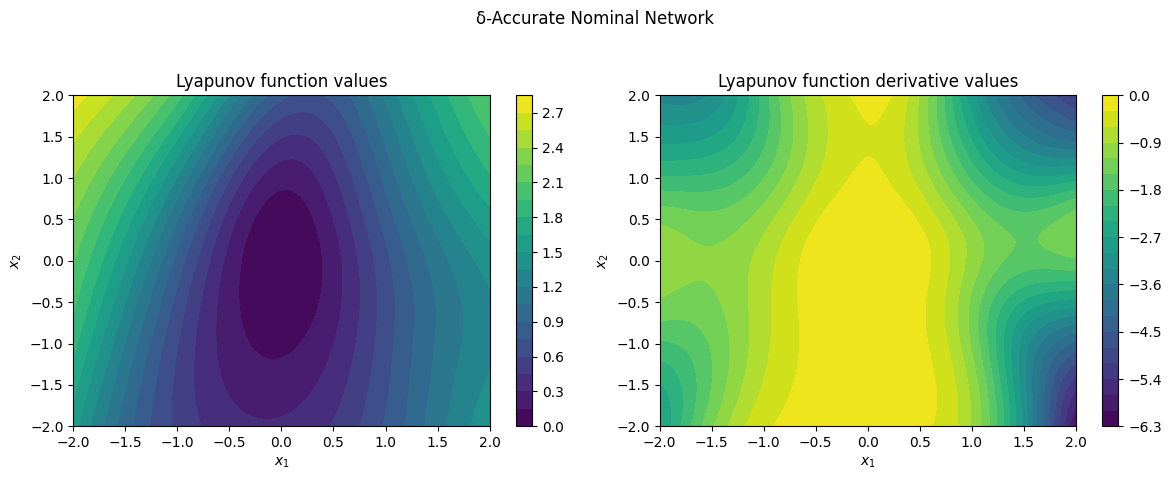

In [35]:
grid_size = 100
x1_range = np.linspace(-2, 2, grid_size)
x2_range = np.linspace(-2, 2, grid_size)
x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)
x_grid = np.column_stack([x1_grid.ravel(), x2_grid.ravel()])
x_tensor = torch.tensor(x_grid, dtype=torch.float32, requires_grad=True)


def plot_nominal_dynamics_lyapunov(net, title):
    # Compute the Lyapunov function values
    V = V_theta(net, x_tensor)
    V = V.detach().numpy().reshape(x1_grid.shape)

    # Compute the Lyapunov function derivative values
    x_dot = system_dynamics(x_tensor)
    V_dot = torch.autograd.grad(V_theta(net, x_tensor), x_tensor, grad_outputs=torch.ones_like(V_theta(net, x_tensor)), create_graph=True)[0]
    V_dot = torch.sum(V_dot * x_dot, dim=1)
    V_dot = V_dot.detach().numpy().reshape(x1_grid.shape)

    mask = np.zeros_like(V_dot)
    mask[V_dot >= 0] = 1

    # Plot the Lyapunov function values
    plt.figure(figsize=(12, 5))
    plt.suptitle(title)
    plt.subplot(1, 2, 1)
    plt.contourf(x1_grid, x2_grid, V, levels=20)
    plt.colorbar()
    plt.title("Lyapunov function values")
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")

    # Plot the Lyapunov function derivative values
    plt.subplot(1, 2, 2)
    plt.contourf(x1_grid, x2_grid, V_dot, levels=20)
    plt.colorbar()
    plt.title("Lyapunov function derivative values")
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")

    # Highlight regions where the Lyapunov function derivative is non-negative
    plt.contour(x1_grid, x2_grid, mask, levels=[0.5], colors='red')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Generate plots for trained networks
delta_symbol = "\u03B4"
plot_nominal_dynamics_lyapunov(net_nominal, f"{delta_symbol}-Accurate Nominal Network")
# plot_nominal_dynamics_lyapunov(net_cc, "Network CC")        
# plot_nominal_dynamics_lyapunov(net_drcc, "Network DRCC")

plt.show()

#Visualize the Real V_dot

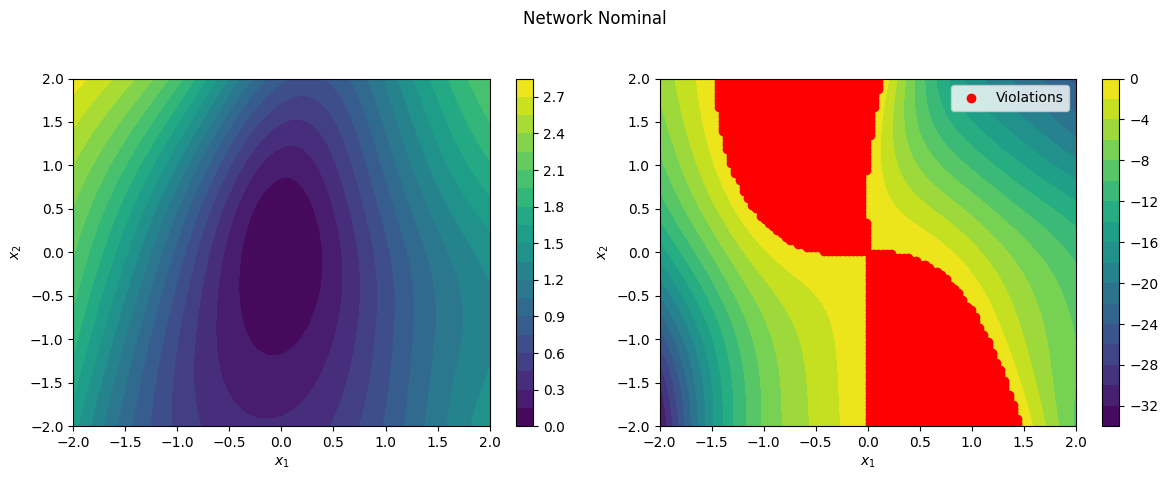

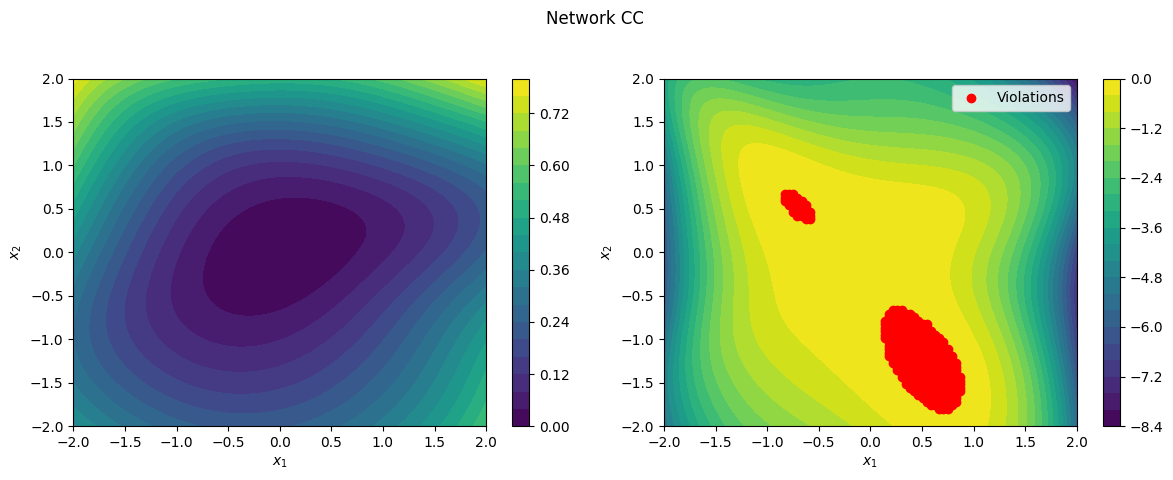

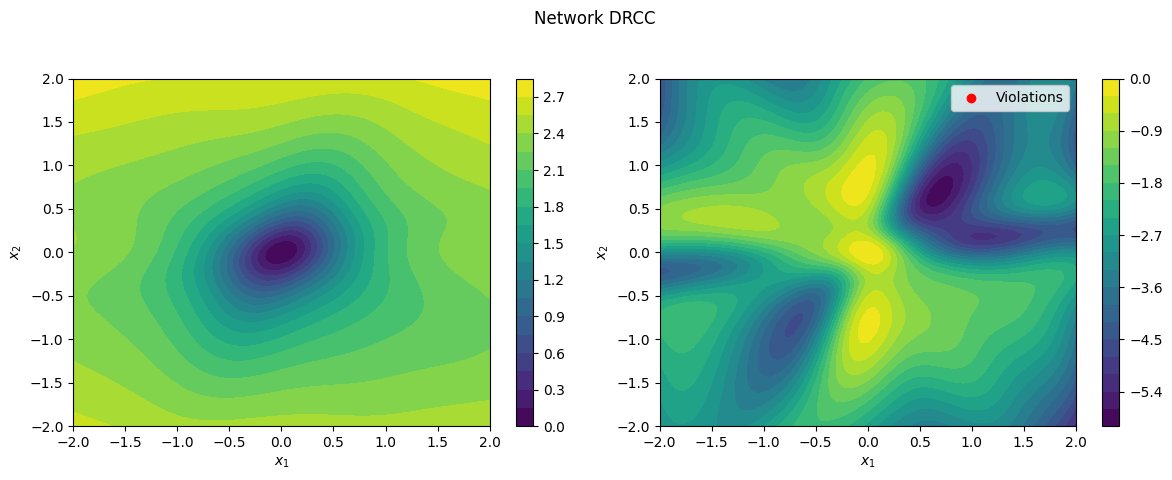

In [33]:
xi_true = torch.tensor([1.9, 3.0], dtype=torch.float32)

def plot_true_dynamics_lyapunov(net, title, xi_true):
    # Compute the Lyapunov function values
    V = V_theta(net, x_tensor)
    V = V.detach().numpy().reshape(x1_grid.shape)

    # Compute the Lyapunov function derivative values
    x_dot = real_dynamics(x_tensor, xi_true)
    V_dot = torch.autograd.grad(V_theta(net, x_tensor), x_tensor, grad_outputs=torch.ones_like(V_theta(net, x_tensor)), create_graph=True)[0]
    V_dot = torch.sum(V_dot * x_dot, dim=1)
    V_dot = V_dot.detach().numpy().reshape(x1_grid.shape)

    mask = np.zeros_like(V_dot)
    mask[V_dot >= 0] = 1

    # Set the violations (positive values) to zero for plotting
    V_dot_plot = np.where(V_dot >= 0, 0, V_dot)

    # Find violation points (positive values)
    violation_points = x_grid[V_dot.ravel() >= 0]

    plt.figure(figsize=(12, 5))
    plt.suptitle(title)
    
    # Plot the Lyapunov function values
    plt.subplot(1, 2, 1)
    plt.contourf(x1_grid, x2_grid, V, levels=20)
    plt.colorbar()
    #plt.title("Lyapunov function values")
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")

    # Plot the Lyapunov function derivative values
    plt.subplot(1, 2, 2)
    plt.contourf(x1_grid, x2_grid, V_dot_plot, levels=20)
    plt.colorbar()
    #plt.title("Lyapunov function derivative values")
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")

    # Scatter violation points
    plt.scatter(violation_points[:, 0], violation_points[:, 1], color='red', label='Violations')
    plt.legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_true_dynamics_lyapunov(net_nominal, "Network Nominal", xi_true)
plot_true_dynamics_lyapunov(net_cc, "Network CC", xi_true)
plot_true_dynamics_lyapunov(net_drcc, "Network DRCC", xi_true)